# Lab3

In [1]:
import os
import logging
import traceback
from pathlib import Path

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
device = "cuda:0"

save_path = "/adls/mase/docs/source/modules/documentation/tutorials/"

# 1) Configure Python's logging to write to a file (error.log)
logging.basicConfig(
    filename= "error.log",
    level=logging.ERROR,
    format='%(asctime)s %(levelname)s: %(message)s'
)

# 2) Define a custom exception hook that logs the traceback
def custom_exc(shell, etype, evalue, tb, tb_offset=None):
    # Format the traceback into a string
    exc_traceback = ''.join(traceback.format_exception(etype, evalue, tb))
    
    # Log to file
    logging.error("Unhandled exception:\n%s", exc_traceback)
    
    # Optionally print something minimal in the notebook cell
    print("An error occurred. See error.log for details.")

# 3) Register the custom exception hook with IPython
get_ipython().set_custom_exc((Exception,), custom_exc)

print("Custom exception hook installed!")


Custom exception hook installed!


## Part 1
In Tutorial 6, all layers allocated to IntegerLinear are allocated the same width and fractional width. This is suboptimal, as different layers may have different sensitivities to quantization.

Modify the code to allow different layers to have widths in the range [8, 16, 32] and fractional widths in the range [2, 4, 8]. Expose this choice as an additional hyperparameter for the Optuna sampler.

Run the search again, and plot a figure that has the number of trials on the x axis, and the maximum achieved accuracy up to that point on the y axis.

In [2]:
from transformers import AutoModel
from pathlib import Path
import dill
from chop.tools import get_tokenized_dataset

checkpoint = "prajjwal1/bert-tiny"
tokenizer_checkpoint = "bert-base-uncased"
dataset_name = "imdb"

save_path = "/adls/mase/docs/source/modules/documentation/tutorials/cw_submission/models"
model = AutoModel.from_pretrained(checkpoint)
with open(f"{Path.home()}{save_path}/tutorial_5_best_model.pkl", "rb") as f:
    base_model = dill.load(f)

dataset, tokenizer = get_tokenized_dataset(
    dataset=dataset_name,
    checkpoint=tokenizer_checkpoint,
    return_tokenizer=True,
)

/home/jw3621/anaconda3/envs/mase-adls/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.


In [3]:
import torch
from chop.nn.quantized.modules.linear import (
    LinearInteger,
    LinearMinifloatDenorm,
    LinearMinifloatIEEE,
    LinearLog,
    LinearBlockFP,
    LinearBlockMinifloat,
    LinearBlockLog,
    LinearBinary,
    LinearBinaryScaling,
    LinearBinaryResidualSign,
)
from chop.tools.utils import deepsetattr
from copy import deepcopy
from chop.tools import get_trainer
import random


search_space = {
    "linear_layer_choices": [
        torch.nn.Linear,
        LinearInteger,
    ],
    "width_choices": [8, 16, 32],
    "frac_width_choices": [2, 4, 8],
}

################################################################################
## construct model function
################################################################################
def construct_model(trial):

    # Fetch the model
    trial_model = deepcopy(base_model)

    # Quantize layers according to optuna suggestions
    for name, layer in trial_model.named_modules():
        if isinstance(layer, torch.nn.Linear):
            new_layer_cls = trial.suggest_categorical(
                f"{name}_type",
                search_space["linear_layer_choices"],
            )

            if new_layer_cls == torch.nn.Linear:
                continue

            kwargs = {
                "in_features": layer.in_features,
                "out_features": layer.out_features,
            }

            # If the chosen layer is integer, define the low precision config
            if new_layer_cls == LinearInteger:
                chosen_width = trial.suggest_categorical(
                    f"{name}_width",
                    search_space["width_choices"]
                )
                chosen_frac_width = trial.suggest_categorical(
                    f"{name}_frac_width",
                    search_space["frac_width_choices"]
                )

                kwargs["config"] = {
                    "data_in_width": chosen_width,
                    "data_in_frac_width": chosen_frac_width,
                    "weight_width": chosen_width,
                    "weight_frac_width": chosen_frac_width,
                    "bias_width": chosen_width,
                    "bias_frac_width": chosen_frac_width,
                }
            # elif... (other precisions)

            # Create the new layer (copy the weights)
            new_layer = new_layer_cls(**kwargs)
            new_layer.weight.data = layer.weight.data
            
            ## copy bias?

            # Replace the layer in the model
            deepsetattr(trial_model, name, new_layer)

    return trial_model


################################################################################
## objective function
################################################################################

def objective(trial):

    # Define the model
    model = construct_model(trial)

    trainer = get_trainer(
        model=model,
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
        num_train_epochs=1,
    )

    trainer.train()
    eval_results = trainer.evaluate()

    trial.set_user_attr("model", model)

    return eval_results["eval_accuracy"]

In [ ]:
from optuna.samplers import GridSampler, RandomSampler, TPESampler
import optuna

sampler = RandomSampler()

study = optuna.create_study(
    direction="maximize",
    study_name="bert-tiny-nas-study",
    sampler=sampler,
)

study.optimize(
    objective,
    n_trials=100,
    timeout=60 * 60 * 24,
)

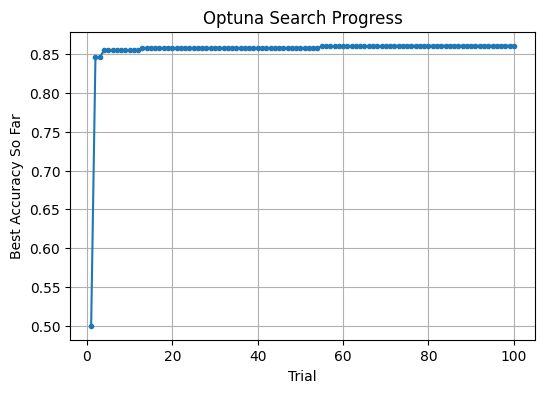

In [12]:
######################################################################
## Plot the data
######################################################################

import matplotlib.pyplot as plt
from pathlib import Path

best_values = []
current_best = 0.0

for i, trial in enumerate(study.trials):
    if trial.value is not None and trial.value > current_best:
        current_best = trial.value
    best_values.append(current_best)

plt.figure(figsize=(6,4))
plt.plot(range(1, len(best_values)+1), best_values, marker='.')
plt.xlabel("Trial")
plt.ylabel("Best Accuracy So Far")
plt.title("Optuna Search Progress")
plt.grid(True)

# save_path = "/adls/mase/docs/source/modules/documentation/tutorials/cw_submission/img"
# plt.savefig(f"{Path.home()}{save_path}/mix_precision_search.png", dpi=300, bbox_inches="tight")

plt.show()


## Part 2
In Section 1 of Tutorial 6, when defining the search space, a number of layers are imported, however only LinearInteger and the full precision nn.Linear are selected.

Now, extend the search to consider all supported precisions for the Linear layer in Mase, including Minifloat, BlockFP, BlockLog, Binary, etc. This may also require changing the model constructor so the required arguments are passed when instantiating each layer.

Run the search again, and plot a figure that has the number of trials on the x axis, and the maximum achieved accuracy up to that point on the y axis. Plot one curve for each precision to compare their performance.

In [2]:
from transformers import AutoModel
from pathlib import Path
import dill
from chop.tools import get_tokenized_dataset

checkpoint = "prajjwal1/bert-tiny"
tokenizer_checkpoint = "bert-base-uncased"
dataset_name = "imdb"

save_path = "/adls/mase/docs/source/modules/documentation/tutorials/cw_submission/models"    
model = AutoModel.from_pretrained(checkpoint)
with open(f"{Path.home()}{save_path}/tutorial_5_best_model.pkl", "rb") as f:
    base_model = dill.load(f)

dataset, tokenizer = get_tokenized_dataset(
    dataset=dataset_name,
    checkpoint=tokenizer_checkpoint,
    return_tokenizer=True,
)

/home/jw3621/anaconda3/envs/mase-adls/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.


In [3]:

import torch
from chop.nn.quantized.modules.linear import (
    LinearInteger,
    LinearMinifloatDenorm,
    LinearMinifloatIEEE,
    LinearLog,
    LinearBlockFP,
    LinearBlockMinifloat,
    LinearBlockLog,
    LinearBinary,
    LinearBinaryScaling,
    LinearBinaryResidualSign,
)
from chop.tools.utils import deepsetattr
from copy import deepcopy
from chop.tools import get_trainer
import random


# search_space = {
#     "linear_layer_choices": [
#         torch.nn.Linear,
#         LinearInteger,
#         LinearMinifloatDenorm,
#         LinearMinifloatIEEE,
#         LinearLog,
#         LinearBlockFP,
#         LinearBlockMinifloat,
#         LinearBlockLog,
#         LinearBinary,
#         LinearBinaryScaling,
#         LinearBinaryResidualSign,
#     ],
#     "width_choices": [8, 16, 32],
#     "frac_width_choices": [2, 4, 8],
#     # "block_size_choices": [[1], [2], [4]],
# }

################################################################################
## construct model function
################################################################################
def construct_model(trial):

    # Fetch the model
    trial_model = deepcopy(base_model)

    # Quantize layers according to optuna suggestions
    for name, layer in trial_model.named_modules():
        if isinstance(layer, torch.nn.Linear):
            new_layer_cls = trial.suggest_categorical(
                f"{name}_type",
                search_space["linear_layer_choices"],
            )

            if new_layer_cls == torch.nn.Linear:
                continue

            kwargs = {
                "in_features": layer.in_features,
                "out_features": layer.out_features,
            }

            chosen_width = trial.suggest_categorical(
                    f"{name}_width",
                    search_space["width_choices"]
                )
            chosen_frac_width = trial.suggest_categorical(
                f"{name}_frac_width",
                search_space["frac_width_choices"]
            )

            # If the chosen layer is integer, define the low precision config
            if new_layer_cls == LinearInteger:

                kwargs["config"] = {
                    "data_in_width": chosen_width,
                    "data_in_frac_width": chosen_frac_width,
                    "weight_width": chosen_width,
                    "weight_frac_width": chosen_frac_width,
                    "bias_width": chosen_width,
                    "bias_frac_width": chosen_frac_width,
                }

            elif new_layer_cls == LinearMinifloatDenorm:
                # Example: Minifloat (denormal) config
                exponent_bits = chosen_width - chosen_frac_width - 1
                bypass = exponent_bits < 1

                kwargs["config"] = {
                    # Optional bypass flag — if True, no quantization is applied
                    "bypass": bypass,
                    "weight_width": chosen_width,
                    "weight_exponent_width": chosen_frac_width,
                    "weight_exponent_bias": exponent_bits,
                    "data_in_width": chosen_width,
                    "data_in_exponent_width": chosen_frac_width,
                    "data_in_exponent_bias": exponent_bits,
                    "bias_width": chosen_width,
                    "bias_exponent_width": chosen_frac_width,
                    "bias_exponent_bias": exponent_bits,
                }

            elif new_layer_cls == LinearMinifloatIEEE:
                exponent_bits = chosen_width - chosen_frac_width - 1
                bypass = exponent_bits < 1

                kwargs["config"] = {
                    # If True, skip all quantization entirely
                    "bypass": bypass,
                    "weight_width": chosen_width,
                    "weight_exponent_width": exponent_bits,
                    "weight_exponent_bias": "None",
                    "data_in_width": chosen_width,
                    "data_in_exponent_width": exponent_bits,
                    "data_in_exponent_bias": "None",
                    "bias_width": chosen_width,
                    "bias_exponent_width": exponent_bits,
                    "bias_exponent_bias": "None",
                }

            elif new_layer_cls == LinearLog:
                # Example: Log domain quant
                kwargs["config"] = {
                    "bypass": False,
                    "weight_width": chosen_width,
                    "weight_exponent_bias": "None",
                    "data_in_width": chosen_width,
                    "data_in_exponent_bias": "None",
                    "bias_width": chosen_width,
                    "bias_exponent_bias": "None",
                }

            elif new_layer_cls == LinearBlockFP:
                exponent_bits = chosen_width - chosen_frac_width - 1
                bypass = exponent_bits < 1
                chosen_block_size = 2
                # chosen_block_size = trial.suggest_categorical(
                #     f"{name}_block_size",
                #     search_space["block_size_choices"]
                # )
                
                kwargs["config"] = {
                    # Optional bypass flag to skip quantization entirely
                    "bypass": False,

                    "weight_width": chosen_width,           # total bits (sign + exponent + fraction)
                    "weight_exponent_width": exponent_bits,  # bits devoted to exponent
                    "weight_exponent_bias": None,   # numeric exponent bias (typical for 4-bit exponent)
                    "weight_block_size": chosen_block_size,     # group size (block) along which to share exponent

                    "data_in_width": chosen_width,
                    "data_in_exponent_width": exponent_bits,
                    "data_in_exponent_bias": None,
                    "data_in_block_size": chosen_block_size,     
                    # Whether to ignore the first dimension (batch dimension) 
                    # when grouping values in blocks
                    "data_in_skip_first_dim": True,  

                    "bias_width": chosen_width,
                    "bias_exponent_width": exponent_bits,
                    "bias_exponent_bias": None,
                    "bias_block_size": chosen_block_size,        # often 1 for biases (they’re smaller in size)
                }

            elif new_layer_cls == LinearBlockMinifloat:
                exponent_bits = chosen_width - chosen_frac_width - 1
                bypass = exponent_bits < 1
                chosen_block_size = 2
                # chosen_block_size = trial.suggest_categorical(
                #     f"{name}_block_size",
                #     search_space["block_size_choices"]
                # )
                
                kwargs["config"] = {
                    # Optional: if True, skip all quantization and pass values as-is
                    "bypass": False,

                    "weight_width": chosen_width,
                    "weight_exponent_width": exponent_bits,
                    "weight_exponent_bias_width": 1,
                    "weight_block_size": chosen_block_size,

                    "data_in_width": chosen_width,
                    "data_in_exponent_width": exponent_bits,
                    "data_in_exponent_bias_width": 1,
                    "data_in_block_size": chosen_block_size,
                    "data_in_skip_first_dim": True,

                    "bias_width": chosen_width,
                    "bias_exponent_width": exponent_bits,
                    "bias_exponent_bias_width": 1,
                    "bias_block_size": chosen_block_size,
                }

            elif new_layer_cls == LinearBlockLog:
                exponent_bits = chosen_width - chosen_frac_width - 1
                bypass = exponent_bits < 1
                chosen_block_size = [2]
                # chosen_block_size = trial.suggest_categorical(
                #     f"{name}_block_size",
                #     search_space["block_size_choices"]
                # )
                kwargs["config"] = {
                    "bypass": False,

                    "weight_width": chosen_width,
                    "weight_exponent_bias_width": exponent_bits,  # bits to store the exponent bias for each block
                    "weight_block_size": chosen_block_size,          # each block has 2 elements sharing the same exponent bias

                    "data_in_width": chosen_width,
                    "data_in_exponent_bias_width": exponent_bits,
                    "data_in_block_size": chosen_block_size,
                    # Often skip first dimension (batch) to block only within each sample/channel
                    "data_in_skip_first_dim": True,  

                    "bias_width": chosen_width,
                    "bias_exponent_bias_width": exponent_bits,
                    "bias_block_size": chosen_block_size,
                }

            elif new_layer_cls == LinearBinary:
                # Example: Basic binary quant
                kwargs["config"] = {
                    "weight_stochastic": True,
                    "weight_bipolar": True,
                }

            elif new_layer_cls == LinearBinaryScaling:
                # Example: Binary scaling with a trainable scaling parameter
                kwargs["config"] = {
                    "data_in_stochastic": True,  
                    "bias_stochastic": False,   
                    "weight_stochastic": True,   

                    "data_in_bipolar": True,      
                    "bias_bipolar": False,        
                    "weight_bipolar": True,  

                    "binary_training": False,     
                }

            elif new_layer_cls == LinearBinaryResidualSign:
                # Example: Residual sign approach
                kwargs["config"] = {
                    "bypass": False,
                    "data_in_stochastic": True,
                    "bias_stochastic": False,
                    "weight_stochastic": True,
                    "data_in_bipolar": True,
                    "bias_bipolar": False,
                    "weight_bipolar": True,
                    "binary_training": True,
                    "data_in_levels": 3,
                    "data_in_residual_sign": True,
                }

            # Create the new layer (copy the weights)
            new_layer = new_layer_cls(**kwargs)
            new_layer.weight.data = layer.weight.data
            
            ## copy bias?

            # Replace the layer in the model
            deepsetattr(trial_model, name, new_layer)

    return trial_model


################################################################################
## objective function
################################################################################

def objective(trial):

    # Define the model
    model = construct_model(trial)

    trainer = get_trainer(
        model=model,
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
        num_train_epochs=1,
    )

    trainer.train()
    eval_results = trainer.evaluate()

    trial.set_user_attr("model", model)

    return eval_results["eval_accuracy"]

In [ ]:
result = {}

In [ ]:
from optuna.samplers import GridSampler, RandomSampler, TPESampler
import optuna

sampler = RandomSampler()
precisions = [
#     LinearInteger,
#     LinearMinifloatDenorm,
#     LinearMinifloatIEEE,
#     LinearLog,
#     LinearBlockFP,
    # LinearBlockMinifloat,
    LinearBlockLog,
    LinearBinary,
    LinearBinaryScaling,
    LinearBinaryResidualSign,
]

for precision_layer in precisions:
    search_space = {
        "linear_layer_choices": [
            torch.nn.Linear,
            precision_layer,
        ],
        "width_choices": [8, 16, 32],
        "frac_width_choices": [2, 4, 8],
        # "block_size_choices": [[1], [2], [4]],
    }

    study = optuna.create_study(
        direction="maximize",
        study_name="bert-tiny-nas-study",
        sampler=sampler,
    )

    study.optimize(
        objective,
        n_trials=50,
        timeout=60 * 60 * 24,
    )
    accuracies = [trial.value for trial in study.trials]
    result[precision_layer.__name__] = accuracies
    logging.error(f"===============A Precision Training Has Finished===============")

[I 2025-02-06 22:39:35,691] A new study created in memory with name: bert-tiny-nas-study
/home/jw3621/anaconda3/envs/mase-adls/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.nn.modules.linear.Linear'> which is of type type.
  warnings.warn(message)
/home/jw3621/anaconda3/envs/mase-adls/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'chop.nn.quantized.modules.linear.LinearBlockLog'> which is of type type.
  warnings.warn(message)
/home/jw3621/adls/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.697500
1000,0.695700
1500,0.695100
2000,0.695700
2500,0.694200
3000,0.695200


In [24]:
print(result.keys())
# study.best_trial

dict_keys(['LinearInteger', 'LinearMinifloatDenorm', 'LinearMinifloatIEEE', 'LinearLog', 'LinearBlockFP', 'LinearBlockLog', 'LinearBinary', 'LinearBinaryScaling', 'LinearBinaryResidualSign'])


In [25]:
import json

# Store the dictionary as JSON
with open("lab3.2.json", "w") as f:
    json.dump(result, f)

# Load the dictionary from JSON
with open("lab3.2.json", "r") as f:
    loaded_dict = json.load(f)

print(loaded_dict)


{'LinearInteger': [0.84576, 0.85392, 0.5, 0.5, 0.85644, 0.5, 0.85392, 0.86036, 0.83448, 0.85732, 0.85116, 0.85, 0.8598, 0.83768, 0.84432, 0.8396, 0.85484, 0.5, 0.85616, 0.5, 0.8412, 0.5, 0.5, 0.85412, 0.84724, 0.82316, 0.5, 0.8608, 0.8436, 0.5, 0.83744, 0.83676, 0.85936, 0.5, 0.85284, 0.84248, 0.5, 0.84524, 0.83844, 0.84544, 0.85988, 0.84396, 0.5, 0.85948, 0.83104, 0.83848, 0.84276, 0.8438, 0.5, 0.8408], 'LinearMinifloatDenorm': [0.84408, 0.82908, 0.85852, 0.859, 0.84384, 0.84404, 0.84248, 0.85608, 0.83896, 0.80788, 0.85844, 0.83732, 0.8454, 0.85964, 0.5, 0.84136, 0.83184, 0.84864, 0.5, 0.83452, 0.85716, 0.5, 0.84532, 0.84352, 0.83876, 0.85868, 0.85904, 0.84668, 0.84232, 0.85484, 0.84172, 0.5, 0.85976, 0.82832, 0.5, 0.8442, 0.84548, 0.8166, 0.8436, 0.5, 0.5, 0.82308, 0.81256, 0.84068, 0.85596, 0.85964, 0.85852, 0.85492, 0.5, 0.84412], 'LinearMinifloatIEEE': [0.85948, 0.85964, 0.85956, 0.85944, 0.85976, 0.8596, 0.86012, 0.8592, 0.85928, 0.85976, 0.85964, 0.85984, 0.8604, 0.85996, 0.8605

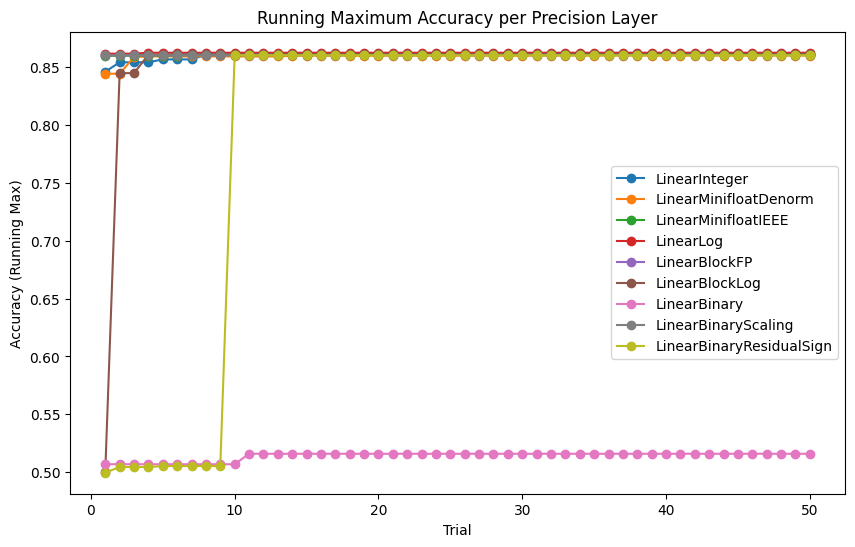

In [26]:
import matplotlib.pyplot as plt

def plot_accuracies(result):

    # Create a new figure
    plt.figure(figsize=(10, 6))
    
    # Plot each precision layer as a separate line
    for precision_layer, accuracies in result.items():
        # Prepare x-axis: trial index (1-based)
        x_values = range(1, len(accuracies) + 1)
        
        # Compute running maximum accuracies
        max_accuracies_so_far = []
        current_max = 0
        for acc in accuracies:
            if acc > current_max:
                current_max = acc
            max_accuracies_so_far.append(current_max)
        
        # Plot the running max instead of the raw accuracy
        plt.plot(x_values, max_accuracies_so_far, marker='o', label=precision_layer)
    
    # Add labels and legend
    plt.xlabel("Trial")
    plt.ylabel("Accuracy (Running Max)")
    plt.title("Running Maximum Accuracy per Precision Layer")
    plt.legend()
    
    # Show the plot
    plt.show()

plot_accuracies(result)



In [ ]:
import os
os._exit(0)